In [58]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex
# display(Latex(f'$x_{i}$'))
def printL(code):
    display(Latex(f'${code}$'))

Decoding functions

In [59]:
# q,n,k,x,F,P are global.
# F: field
# PF: polynomial ring over F

def poly_G(v):
    # Precompute common polynomial factor
    G = PF(1)
    for i in range(len(v)):
        G *= Y-v[i]
    return G

def poly_L(i,G,v):
    # Precompute Lagrangian polynomial
    L_i = G/(Y-v[i])
    denom = F(1)
    for h in range(len(v)):
        if h == i:
            continue
        denom *= v[i]-v[h]
    L_i /= denom
    return L_i

def sys_G_RS():
    # Compute a very systematic generator matrix
    eye = matrix.identity(F,k)
    G_RS = eye.augment(matrix.zero(F,nrows=k,ncols=n-k))
    G = poly_G(x[:k])
    #print(G)
    
    for i in range(k):
        L_i = poly_L(i,G,x[:k])
        #print(L_i)
        for j in range(k,n):
            G_RS[i,j] = L_i(x[j])
    
    return G_RS

def is_k_reduced(P):
    cond1 = P[0,0].degree() >= P[0,1].degree() + (k-1)
    cond2 = P[1,0].degree() < P[1,1].degree() + (k-1)
    return cond1 and cond2

# def RS_decoder(r):
#     # r: received message
#     G = poly_G(x)
#     R = PF(0)
#     for i in range(n):
#         L_i = poly_L(i,G,x)
#         R += r[0,i]*L_i

#     P = matrix(PF, [[G,0],[-R,1]])
#     #print(P)
#     #printL(latex(P))
#     while not is_k_reduced(P):
#         (qP, rP) = P[0][0].quo_rem(P[1][0])
#         P = matrix(PF, [ [P[1,0], P[1,1]], [rP, P[0,1] - qP*P[1,1]] ])
#         #printL(latex(P))
    
#     if P[0,0].degree() < P[1,1].degree() + (k-1):
#         f = -P[0,0]/P[0,1]
#     else:
#         f = -P[1,0]/P[1,1]
    
#     # c = []
#     # for i in range(n):
#     #     c.append(f(x[i]))
#     c = matrix(F,nrows=1,ncols=n)
#     for i in range(n):
#         c[0,i] = f(x[i])
#     return c

def RS_decoder(r):
    # r: received message
    # G_poly = poly_G(x)
    # L[i] = L_i = poly_L(i,G,x)
    # G_poly and L are precomputed globally
    #T1 = time.time()
    R = PF(0)
    for i in range(n):
        R += r[0,i]*L[i]
    #print(f"Compute R: {time.time()-T1}")

    P = matrix(PF, [[G_poly,0],[-R,1]])
    #print(P)
    #printL(latex(P))
    while not is_k_reduced(P):
        (qP, rP) = P[0][0].quo_rem(P[1][0])
        P = matrix(PF, [ [P[1,0], P[1,1]], [rP, P[0,1] - qP*P[1,1]] ])
        #printL(latex(P))
    
    if P[0,0].degree() < P[1,1].degree() + (k-1):
        f = -P[0,0]/P[0,1]
    else:
        f = -P[1,0]/P[1,1]
    
    # c = []
    # for i in range(n):
    #     c.append(f(x[i]))
    c = matrix(F,nrows=1,ncols=n)
    for i in range(n):
        c[0,i] = f(x[i])
    return c


Simulation functions

In [60]:
def sim_chan(p,c):
    # p: cross-over probability
    # c: codeword sent through channel
    # r: received codeword
    # alpha: correct letter
    # beta: wrong letter
    # alphabet: global variable that contains F.list()
    r = matrix(F,nrows=1,ncols=n)
    #alphabet = F.list()
    for i in range(n):
        if random.uniform(0,1) > p:
            r[0,i] = c[0,i]
            continue
        
        alpha_idx = alphabet.index(c[0,i])
        beta_idx = random.randint(0,q-2)
        if beta_idx >= alpha_idx:
            beta_idx += 1
        r[0,i] = alphabet[beta_idx]
        # alpha = c[0,i]
        # r[0,i] = random.choice([ll for ll in alphabet if ll != alpha])
    return r

def random_msg():
    m = matrix(F,nrows=1,ncols=k)
    # alphabet = F.list()
    for i in range(k):
        m[0,i] = alphabet[random.randint(0,q-1)]
    return m


In [51]:
# testing example from notes
q = 11; n = 6; k = 2
F.<X> = FiniteField(q)
PF.<Y> = PolynomialRing(F)
x = F.list()[1:n+1]

G = sys_G_RS()
print(G)

c = RS_decoder(matrix(F,[3,4,1,6,6,8]))
print(c)

[ 1  0 10  9  8  7]
[ 0  1  2  3  4  5]


NameError: name 'L' is not defined

In [46]:
# testing inspection (show all vectors)
q = 11; n = 6; k = 2
T1 = time.time()

F.<X> = FiniteField(q)
PF.<Y> = PolynomialRing(F)
alphabet = F.list()
x = F.list()[:n]

G = sys_G_RS()
print(G)

p = 0.3
m = random_msg()
c = m*G
print(f"Codeword sent: {c}")
r = sim_chan(p,c)
print(f"Codeword received: {r}")
print(f"Error vector: {r-c}")

c_hat = RS_decoder(r)
print(f"Decoded message: {c_hat}")
print(f"Decoded error: {c_hat-c}")
T2 = time.time()
print(T2-T1)

[ 1  0 10  9  8  7]
[ 0  1  2  3  4  5]
Codeword sent: [2 3 4 5 6 7]
Codeword received: [ 2  3  4 10  6  4]
Error vector: [0 0 0 5 0 8]
Precalc: 6.842613220214844e-05
Decoded message: [2 3 4 5 6 7]
Decoded error: [0 0 0 0 0 0]
0.002378702163696289


In [62]:
# probability simulation
q = 256; n = 255; k = 251
F.<X> = FiniteField(q)
PF.<Y> = PolynomialRing(F)
alphabet = F.list()
x = F.list()[1:]

G = sys_G_RS()
p = 0.001

# Precomputing
G_poly = poly_G(x)
L = []
for i in range(n):
     L.append( poly_L(i,G_poly,x) )

failures = 0
N = 2000
for i in range(N):
    # T1 = time.time()
    m = random_msg()
    # print(f"random_msg: {time.time()-T1}")
    c = m*G
    
    # T1 = time.time()
    r = sim_chan(p,c)
    # print(f"sim_chan: {time.time()-T1}")

    # T1 = time.time()
    c_hat = RS_decoder(r)
    # print(f"RS_decoder: {time.time()-T1}")
    if c_hat != c:
        failures += 1

print(f"Probability of failure: {failures/N}")

Probability of failure: 1/500


In [148]:
# testing with simulation
#random.seed(6)

#Ns = matrix(lambda i,j: 2^(j+1),nrows=1,ncols=7)
# Qs = []
# for i in range(2,9):
#     Qs.append(2^i)
Qs = [29,71,113,173,229,281,349,409,463,541,601,659,733,809,863,
      941,1087,1229,1381,1597,1823,2131]
Ns = []
Ts = []
for i in range(len(Qs)):
    q = Qs[i]; n = q // 2 + 1; k = n // 2
    Ns.append(n)
    T1 = time.time()

    F.<X> = FiniteField(q)
    PF.<Y> = PolynomialRing(F)
    x = F.list()[:n]

    G = sys_G_RS()
    #print(G)

    p = 0.1
    m = random_msg()
    c = m*G
    r = sim_chan(p,c)
    c_hat = RS_decoder(r)
    T2 = time.time()
    print(T2-T1)
    Ts.append(T2-T1)



0.0034461021423339844
0.0019981861114501953
0.003037691116333008
0.0054476261138916016
0.008999347686767578
0.014435291290283203
0.023820161819458008
0.03205227851867676
0.03582143783569336
0.058338165283203125
0.07564258575439453
0.0952157974243164
0.11867666244506836
0.1492471694946289
0.17418384552001953
0.21518611907958984
0.2977581024169922
0.3957369327545166
0.5330612659454346
0.7742393016815186
1.1348352432250977
1.6380279064178467


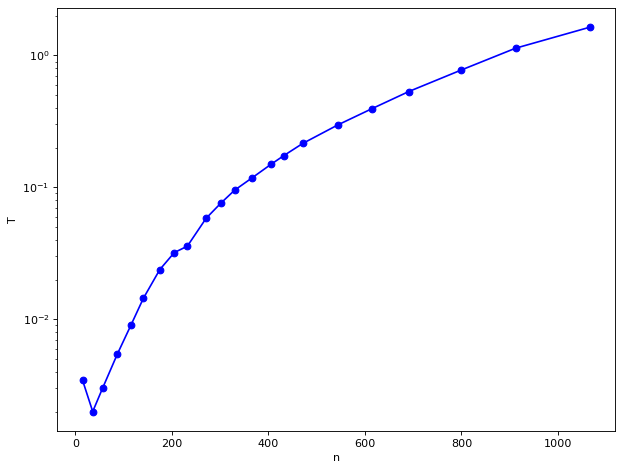

In [149]:
plt.figure(figsize=(9,7), dpi=80)
plt.plot(Ns,Ts,'bo-')
plt.xlabel("n")
plt.ylabel("T")
plt.yscale("log")

In [150]:
# 3
# def poly_G(x,k):
#     G = P(1)
#     for i in range(k):
#         G *= Y-x[i]
#     return G

# def sys_G_RS(x,n,k):
#     eye = matrix.identity(F,k)
#     G_RS = eye.augment(matrix.zero(F,nrows=k,ncols=n-k))
#     G = poly_G(x,k)
#     print(G)
    
#     for i in range(k):
#         L_i = G/(Y-x[i])
#         denom = F(1)
#         for h in range(k):
#             if h == i:
#                 continue
#             denom *= x[i]-x[h]
#         L_i /= denom
#         print(L_i)
#         for j in range(k,n):
#             G_RS[i,j] = L_i(x[j])
    
#     return G_RS

# def RS_decoder(x,r,n,k)